In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import mlflow
from torchinfo import summary
import mlflow.pytorch
from model import Net
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import yaml
import os
from tqdm import tqdm
from data_loader import load_data

c:\Users\minakshi.mathpal\Anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

BASE_DIR = os.getcwd()
MODELS_DIR = os.path.join(BASE_DIR, "models")
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")   

CUDA Available? False


In [9]:
def create_training_plots(train_losses, val_losses, train_accs, val_accs):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Losses')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracies')
    ax2.legend()
    
    plt.tight_layout()
    return fig


In [10]:
def train_epoch(model, device, train_loader, optimizer,scheduler):
    train_losses = []    
    train_acc = []
    
    model.train()
    pbar = tqdm(train_loader)
    running_loss=0.0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
                # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
   # Predict
        y_pred = model(data)
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        l2_lambda = 0.000025
        l1_parameters = []
        for parameter in model.parameters():
            l1_parameters.append(parameter.view(-1))
        l1 = l2_lambda * model.compute_l1_loss(torch.cat(l1_parameters))
        loss += l1
        train_losses.append(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update pbar-tqdm
        
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc= f'LR={optimizer.param_groups[0]["lr"]} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
    running_loss+=loss.item()    
    return running_loss/len(train_loader.dataset), 100. * correct/processed

def test(model, device, test_loader):  
    test_losses = []  
    test_acc = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses,accuracy

In [12]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              64
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1,


Using device: cpu
Epoch 1


LR=0.0005421928411704223 Loss=0.5021984577178955 Batch_id=468 Accuracy=69.13: 100%|██████████| 469/469 [01:06<00:00,  7.05it/s] 



Test set: Average loss: 0.4802, Accuracy: 9474/10000 (94.74%)

Epoch 2


LR=0.0015612063714378652 Loss=0.17118574678897858 Batch_id=468 Accuracy=96.00: 100%|██████████| 469/469 [01:08<00:00,  6.82it/s]



Test set: Average loss: 0.1029, Accuracy: 9737/10000 (97.37%)

Epoch 3


LR=0.0025795125108930036 Loss=0.062479373067617416 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [01:07<00:00,  6.91it/s]



Test set: Average loss: 0.0502, Accuracy: 9865/10000 (98.65%)

Epoch 4


LR=0.0029999998685507905 Loss=0.0868898257613182 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [01:11<00:00,  6.55it/s]  



Test set: Average loss: 0.0429, Accuracy: 9868/10000 (98.68%)

Epoch 5


LR=0.002971056435944751 Loss=0.14267203211784363 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [01:05<00:00,  7.11it/s]  



Test set: Average loss: 0.0316, Accuracy: 9907/10000 (99.07%)

Epoch 6


LR=0.00288558343524966 Loss=0.08560457825660706 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [01:16<00:00,  6.10it/s]   



Test set: Average loss: 0.0327, Accuracy: 9907/10000 (99.07%)

Epoch 7


LR=0.0027468655459484182 Loss=0.06435062736272812 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [01:09<00:00,  6.71it/s] 



Test set: Average loss: 0.0320, Accuracy: 9894/10000 (98.94%)

Epoch 8


LR=0.0025602336187329853 Loss=0.03931136429309845 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [01:06<00:00,  7.05it/s] 



Test set: Average loss: 0.0326, Accuracy: 9898/10000 (98.98%)

Epoch 9


LR=0.0023328598139018583 Loss=0.045134492218494415 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [01:23<00:00,  5.64it/s]



Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

Epoch 10


LR=0.002073481979262 Loss=0.08390370011329651 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [01:10<00:00,  6.65it/s]     



Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

Epoch 11


LR=0.0017920678595378524 Loss=0.0320991575717926 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [01:06<00:00,  7.11it/s]  



Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

Epoch 12


LR=0.0014994320415315603 Loss=0.05795872583985329 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [01:15<00:00,  6.25it/s] 



Test set: Average loss: 0.0244, Accuracy: 9929/10000 (99.29%)

Epoch 13


LR=0.001206820355617047 Loss=0.058760322630405426 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [01:09<00:00,  6.76it/s] 



Test set: Average loss: 0.0224, Accuracy: 9935/10000 (99.35%)

Epoch 14


LR=0.0009254777047854836 Loss=0.06829403340816498 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [01:24<00:00,  5.52it/s] 



Test set: Average loss: 0.0193, Accuracy: 9933/10000 (99.33%)

Epoch 15


LR=0.0006662159293295504 Loss=0.03210628405213356 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [01:16<00:00,  6.14it/s] 



Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

Epoch 16


LR=0.0004389983138843405 Loss=0.04217803105711937 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [01:04<00:00,  7.27it/s]  



Test set: Average loss: 0.0179, Accuracy: 9938/10000 (99.38%)

Epoch 17


LR=0.0002525567039863061 Loss=0.03159928321838379 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [01:08<00:00,  6.82it/s]  



Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

Epoch 18


LR=0.00011405594614616988 Loss=0.02245166525244713 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [01:10<00:00,  6.62it/s] 



Test set: Average loss: 0.0174, Accuracy: 9942/10000 (99.42%)

Epoch 19


LR=2.8818546815607874e-05 Loss=0.020406100898981094 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [01:10<00:00,  6.61it/s]



Test set: Average loss: 0.0168, Accuracy: 9941/10000 (99.41%)

Epoch 20


LR=1.2013144920979888e-07 Loss=0.020385373383760452 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [01:19<00:00,  5.89it/s]



Test set: Average loss: 0.0167, Accuracy: 9942/10000 (99.42%)



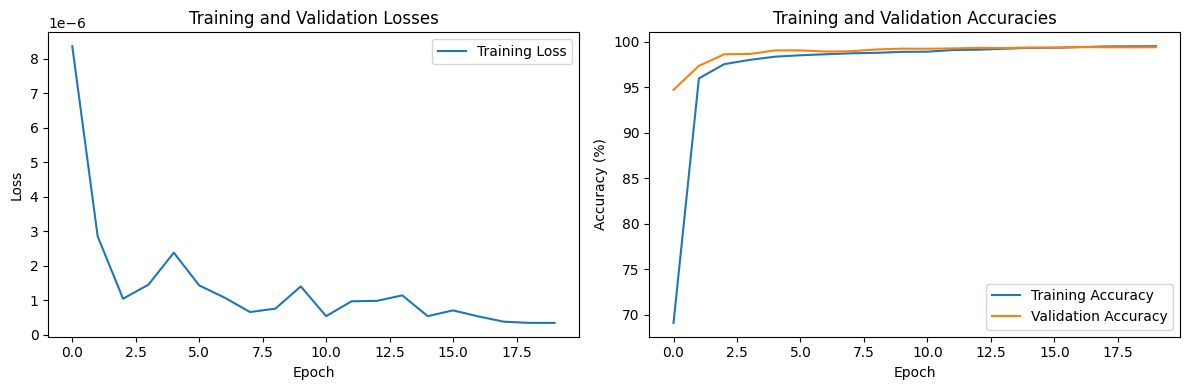

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
# Create model by passing entire config
model = Net().to(device)
# criterion = get_loss_function(config)

train_loader, test_loader = load_data()
EPOCHS=20
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.003,
        epochs=EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.2,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1000.0
    )
sch_dict = scheduler.state_dict()
sch_dict['total_steps'] = sch_dict['total_steps'] + EPOCHS * int(len(train_loader))
scheduler.load_state_dict(sch_dict)
losses = {"train": [], "val": []}
accuracy = {"train": [], "val": []}
for epoch in range(20):
    print(f"Epoch {epoch+1}")
    train_epoch_loss,train_epoch_accuracy=train_epoch(model,device,train_loader,optimizer,scheduler)
    val_epoch_loss,val_epoch_accuracy = test(model=model,test_loader=test_loader,device=device)
    
    losses["train"].append(train_epoch_loss)
    accuracy["train"].append(train_epoch_accuracy)

    losses["val"].append(val_epoch_loss)
    accuracy["val"].append(val_epoch_accuracy)
fig = create_training_plots(losses["train"], losses["val"], accuracy["train"], accuracy["val"])

if not os.path.exists(ARTIFACTS_DIR):
    os.makedirs(ARTIFACTS_DIR)
plt.savefig(os.path.join(ARTIFACTS_DIR, "training_plots.png"))

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
torch.save(model.state_dict(), os.path.join(MODELS_DIR, f"model_{timestamp}.pth"))